# GAMMA Challenge Subtask 1 Glaucoma Grading - Marco

- Unzip files in first time runs.

In [ ]:
# !cp data/data?????/training_data.zip ./
# !cp data/data?????/validation_data.zip ./
# !unzip training_data.zip > /dev/null
# !unzip validation_data.zip > /dev/null

In [1]:
!pwd

/home/yanggq/Downloads/GlaucomaRecognition-main/CodeOfTask1


In [ ]:
!unzip -o /home/aistudio/data/data100624/GAMMA_training_data.zip  -d /home/aistudio/

In [ ]:
!rm */.DS_Store
!rm */*/.DS_Store
!rm */*/*/.DS_Store

- Import packages

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.vision.models import resnet34, resnet50

import transforms as trans

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Config

In [3]:
batchsize = 4 # 4 patients per iter, i.e, 20 steps / epoch
oct_img_size = [512, 512]
image_size = 256
iters = 1000 # For demonstration purposes only, far from reaching convergence
val_ratio = 0.2 # 80 / 20
trainset_root = "/home/yanggq/project/grading/Glaucoma_grading/training/multi-modality_images"
# test_root = ""
num_workers = 4
init_lr = 1e-4
optimizer_type = "adam"

# Train / Val splitition

In [4]:
filelists = os.listdir(trainset_root)
train_filelists, val_filelists = train_test_split(filelists, test_size=val_ratio, random_state=12)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))
print(val_filelists)

Total Nums: 100, train: 80, val: 20
['0053', '0051', '0074', '0008', '0086', '0013', '0084', '0097', '0014', '0002', '0058', '0033', '0069', '0052', '0005', '0077', '0075', '0061', '0045', '0098']


# DataLoader

- GAMMA_sub1_dataset:
	
    Load oct images and fundus images according to `patient id`
        

In [7]:
class GAMMA_sub1_dataset(paddle.io.Dataset):
    """
    getitem() output:
    
    	fundus_img: RGB uint8 image with shape (3, image_size, image_size)
        
        oct_img:    Uint8 image with shape (256, oct_img_size[0], oct_img_size[1])
    """

    def __init__(self,
                 img_transforms,
                 oct_transforms,
                 dataset_root,
                 label_file='',
                 filelists=None,
                 num_classes=3,
                 mode='train'):

        self.dataset_root = dataset_root
        self.img_transforms = img_transforms
        self.oct_transforms = oct_transforms
        self.mode = mode.lower()
        self.num_classes = num_classes
        
        if self.mode == 'train':
            label = {row['data']: row[1:].values 
                        for _, row in pd.read_excel(label_file).iterrows()}

            self.file_list = [[f, label[int(f)]] for f in os.listdir(dataset_root)]
        elif self.mode == "test":
            self.file_list = [[f, None] for f in os.listdir(dataset_root)]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists]

    def __getitem__(self, idx):
        real_index, label = self.file_list[idx]

        fundus_img_path = os.path.join(self.dataset_root, real_index, real_index + ".jpg")
        oct_series_list = sorted(os.listdir(os.path.join(self.dataset_root, real_index, real_index)), 
                                    key=lambda x: int(x.strip("_")[0]))

        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB
        oct_series_0 = cv2.imread(os.path.join(self.dataset_root, real_index, real_index, oct_series_list[0]), 
                                    cv2.IMREAD_GRAYSCALE)
        oct_img = np.zeros((len(oct_series_list), oct_series_0.shape[0], oct_series_0.shape[1], 1), dtype="uint8")

        for k, p in enumerate(oct_series_list):
            oct_img[k] = cv2.imread(
                os.path.join(self.dataset_root, real_index, real_index, p), cv2.IMREAD_GRAYSCALE)[..., np.newaxis]

        if self.img_transforms is not None:
            fundus_img = self.img_transforms(fundus_img)
        if self.oct_transforms is not None:
            oct_img = self.oct_transforms(oct_img)
 
        # normlize on GPU to save CPU Memory and IO consuming.
        # fundus_img = (fundus_img / 255.).astype("float32")
        # oct_img = (oct_img / 255.).astype("float32")

        fundus_img = fundus_img.transpose(2, 0, 1) # H, W, C -> C, H, W
        oct_img = oct_img.squeeze(-1) # D, H, W, 1 -> D, H, W

        if self.mode == 'test':
            return fundus_img, oct_img, real_index
        if self.mode == "train":
            label = label.argmax()
            return fundus_img, oct_img, label

    def __len__(self):
        return len(self.file_list)

In [8]:
img_train_transforms = trans.Compose([
    trans.RandomResizedCrop(
        image_size, scale=(0.90, 1.1), ratio=(0.90, 1.1)),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    trans.RandomRotation(30)
])

oct_train_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

img_val_transforms = trans.Compose([
    trans.CropCenterSquare(),
    trans.Resize((image_size, image_size))
])

oct_val_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

In [9]:
_train = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_train_transforms,
                        oct_transforms=oct_train_transforms,
                        label_file='/home/yanggq/project/grading/Glaucoma_grading/training/glaucoma_grading_training_GT.xlsx')

_val = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_val_transforms,
                        oct_transforms=oct_val_transforms,
                        label_file='/home/yanggq/project/grading/Glaucoma_grading/training/glaucoma_grading_training_GT.xlsx')

- Visualzation and check dataloader 

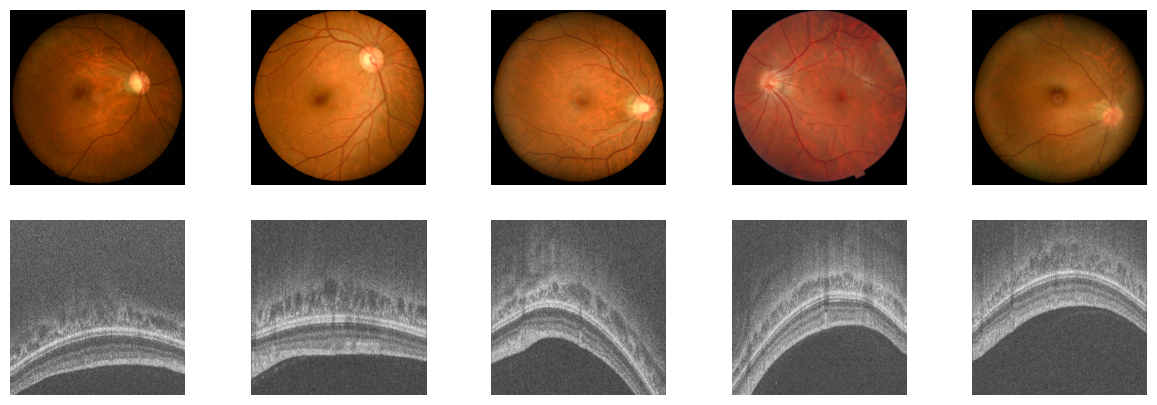

In [10]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = _train.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

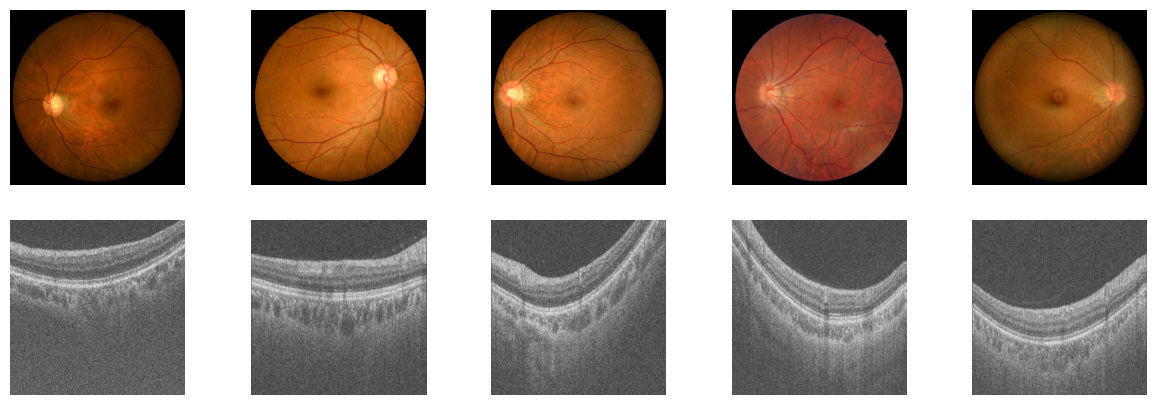

In [11]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = _val.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

# Network

In [12]:
class Model(nn.Layer):
    """
    simply create a 2-branch network, and concat global pooled feature vector.
    each branch = single resnet34
    """
    def __init__(self):
        super(Model, self).__init__()
        self.fundus_branch = resnet34(pretrained=True, num_classes=0) # remove final fc
        self.oct_branch = resnet34(pretrained=True, num_classes=0) # remove final fc
        self.decision_branch = nn.Linear(512 * 1 * 2, 3) # ResNet34 use basic block, expansion = 1
        
        # replace first conv layer in oct_branch
        self.oct_branch.conv1 = nn.Conv2D(256, 64,
                                        kernel_size=7,
                                        stride=2,
                                        padding=3,
                                        bias_attr=False)

    def forward(self, fundus_img, oct_img):
        b1 = self.fundus_branch(fundus_img)
        b2 = self.oct_branch(oct_img)
        b1 = paddle.flatten(b1, 1)
        b2 = paddle.flatten(b2, 1)
        logit = self.decision_branch(paddle.concat([b1, b2], 1))

        return logit

In [13]:
class Model_resnet50(nn.Layer):
    """
    simply create a 2-branch network, and concat global pooled feature vector.
    each branch = single resnet34
    """
    def __init__(self):
        super(Model_resnet50, self).__init__()
        self.fundus_branch = resnet50(pretrained=True, num_classes=0) # remove final fc
        self.oct_branch = resnet50(pretrained=True, num_classes=0) # remove final fc
        self.decision_branch = nn.Linear(512 * 4 * 2, 3) # ResNet34 use bottleneck block, expansion = 4
        
        # replace first conv layer in oct_branch
        self.oct_branch.conv1 = nn.Conv2D(256, 64,
                                        kernel_size=7,
                                        stride=2,
                                        padding=3,
                                        bias_attr=False)

    def forward(self, fundus_img, oct_img):
        b1 = self.fundus_branch(fundus_img)
        b2 = self.oct_branch(oct_img)
        b1 = paddle.flatten(b1, 1)
        b2 = paddle.flatten(b2, 1)
        logit = self.decision_branch(paddle.concat([b1, b2], 1))

        return logit

# Utils

In [14]:
def train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, log_interval, eval_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_kappa_list = []
    best_kappa = 0.
    while iter < iters:
        for data in train_dataloader:
            iter += 1
            if iter > iters:
                break
            fundus_imgs = (data[0] / 255.).astype("float32")
            oct_imgs = (data[1] / 255.).astype("float32")
            labels = data[2].astype('int64')

            logits = model(fundus_imgs, oct_imgs)
            print("logits",logits.shape)
            print("labels",labels.shape)

            loss = criterion(logits, labels)
            # acc = paddle.metric.accuracy(input=logits, label=labels.reshape((-1, 1)), k=1)
            for p, l in zip(logits.numpy().argmax(1), labels.numpy()):
                avg_kappa_list.append([p, l])

            loss.backward()
            optimizer.step()

            model.clear_gradients()
            #avg_loss_list.append(loss.numpy()[0])
            avg_loss_list.append(loss.numpy().item())   # 推荐：numpy 标量 -> Python float

            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_kappa_list = np.array(avg_kappa_list)
                avg_kappa = cohen_kappa_score(avg_kappa_list[:, 0], avg_kappa_list[:, 1], weights='quadratic')
                avg_loss_list = []
                avg_kappa_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_kappa={:.4f}".format(iter, iters, avg_loss, avg_kappa))

            if iter % eval_interval == 0:
                avg_loss, avg_kappa = val(model, val_dataloader, criterion)
                print("[EVAL] iter={}/{} avg_loss={:.4f} kappa={:.4f}".format(iter, iters, avg_loss, avg_kappa))
                if avg_kappa >= best_kappa:
                    best_kappa = avg_kappa
                    paddle.save(model.state_dict(),
                            os.path.join('trained_models', "best_model_{:.4f}".format(best_kappa), 'model.pdparams'))
                    paddle.save(optimizer.state_dict(), 
                            os.path.join('trained_models',"best_model_{:.4f}".format(best_kappa), 'optimizer.pdopt'))
                model.train()

def val(model, val_dataloader, criterion):
    model.eval()
    avg_loss_list = []
    cache = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_imgs = (data[0] / 255.).astype("float32")
            oct_imgs = (data[1] / 255.).astype("float32")
            labels = data[2].astype('int64')
            
            logits = model(fundus_imgs, oct_imgs)
            for p, l in zip(logits.numpy().argmax(1), labels.numpy()):
                cache.append([p, l])

            loss = criterion(logits, labels)
            # acc = paddle.metric.accuracy(input=logits, label=labels.reshape((-1, 1)), k=1)
            #avg_loss_list.append(loss.numpy()[0])
            avg_loss_list.append(loss.numpy().item())   # 推荐：numpy 标量 -> Python float
    cache = np.array(cache)
    kappa = cohen_kappa_score(cache[:, 0], cache[:, 1], weights='quadratic')
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, kappa

# Training

In [15]:
img_train_transforms = trans.Compose([
    trans.RandomResizedCrop(
        image_size, scale=(0.90, 1.1), ratio=(0.90, 1.1)),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    trans.RandomRotation(30)
])

oct_train_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

img_val_transforms = trans.Compose([
    trans.CropCenterSquare(),
    trans.Resize((image_size, image_size))
])

oct_val_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

train_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_train_transforms,
                        oct_transforms=oct_train_transforms,
                        filelists=train_filelists,
                        label_file='/home/yanggq/project/grading/Glaucoma_grading/training/glaucoma_grading_training_GT.xlsx')

val_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root, 
                        img_transforms=img_val_transforms,
                        oct_transforms=oct_val_transforms,
                        filelists=val_filelists,
                        label_file='/home/yanggq/project/grading/Glaucoma_grading/training/glaucoma_grading_training_GT.xlsx')

In [16]:
train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

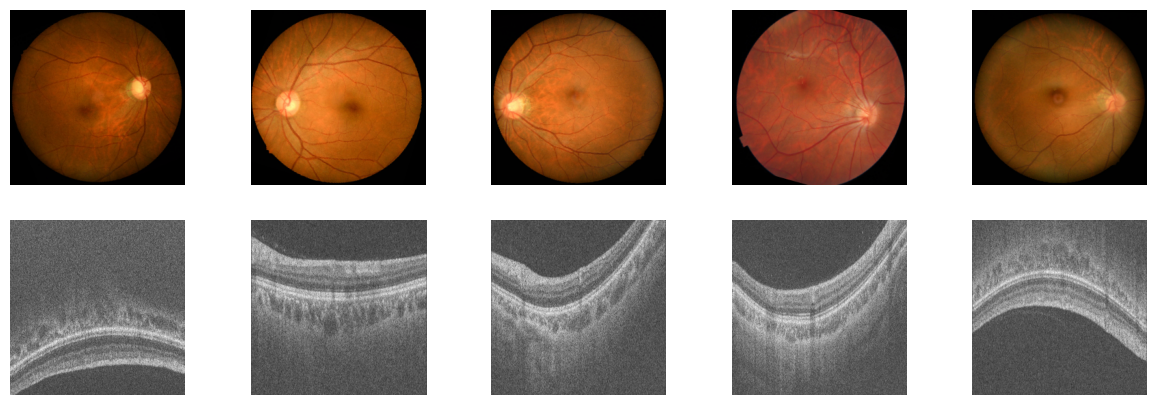

In [17]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = train_dataset.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

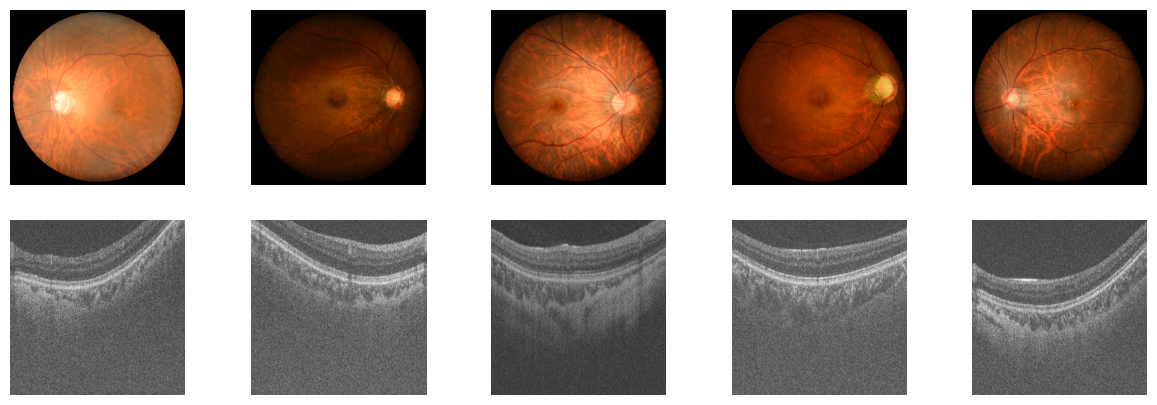

In [18]:
plt.figure(figsize=(15, 5))

for i in range(5):
    fundus_img, oct_img, lab = val_dataset.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(oct_img[100], cmap='gray')
    plt.axis("off")

In [20]:
model = Model()

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())

criterion = nn.CrossEntropyLoss()

W0816 14:32:03.248224 65062 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 8.9, Driver API Version: 12.8, Runtime API Version: 11.8
W0816 14:32:03.249022 65062 gpu_resources.cc:164] device: 0, cuDNN Version: 9.8.


In [1]:
train(model, iters, train_loader, val_loader, optimizer, criterion, log_interval=10, eval_interval=100)

NameError: name 'train' is not defined

# Incremental Training

In [28]:
model= Model() # 

optimizer_type = 'sgd'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(1e-4, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=1e-4, parameters=model.parameters(), 
                                     weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
    

criterion = nn.CrossEntropyLoss()

para_state_dict = paddle.load("trained_models/best_model_0.9398/model.pdparams")
# opt_state_dict = paddle.load("trained_models/best_model_0.9276/optimizer.pdopt")

model.set_state_dict(para_state_dict)
# optimizer.set_state_dict(opt_state_dict)

train(model, iters, train_loader, val_loader, optimizer, criterion, log_interval=10, eval_interval=100)

OSError: (External) CUDA error(719), unspecified launch failure. 
  [Hint: 'cudaErrorLaunchFailure'. An exception occurred on the device while executing a kernel. Common causes include dereferencing an invalid device pointerand accessing out of bounds shared memory. Less common cases can be system specific - more information about these cases canbe found in the system specific user guide. This leaves the process in an inconsistent state and any further CUDA work willreturn the same error. To continue using CUDA, the process must be terminated and relaunched.] (at /paddle/paddle/phi/backends/gpu/cuda/cuda_info.cc:272)


# Experimental Records  
1st Training resnet34 0.8162 (700 iters)  
1st Incremental Training 0.9398 (300 iters)  


# Inference

In [ ]:
!unzip -o /home/aistudio/data/data103109/val_data.zip  -d /home/aistudio/val_data

In [51]:
best_model_path = "trained_models/best_model_1.0000/model.pdparams"
model = Model()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

testset_root = 'val_data/multi-modality_images' 

img_test_transforms = trans.Compose([
    trans.CropCenterSquare(),
    trans.Resize((image_size, image_size))
])

oct_test_transforms = trans.Compose([
    trans.CenterCrop([256] + oct_img_size)
])

test_dataset = GAMMA_sub1_dataset(dataset_root=testset_root, 
                        img_transforms=img_test_transforms,
                        oct_transforms=oct_test_transforms,
                        mode='test')

2021-09-05 23:44:20,263 - INFO - unique_endpoints {''}
2021-09-05 23:44:20,265 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-09-05 23:44:20,633 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams
2021-09-05 23:44:21,464 - INFO - unique_endpoints {''}
2021-09-05 23:44:21,465 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams md5 checking...
2021-09-05 23:44:21,829 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet34.pdparams


In [52]:
cache = []
for fundus_img, oct_img, idx in test_dataset:
    fundus_img = fundus_img[np.newaxis, ...]
    oct_img = oct_img[np.newaxis, ...]

    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))
    oct_img = paddle.to_tensor((oct_img / 255.).astype("float32"))

    logits = model(fundus_img, oct_img)
    cache.append([idx, logits.numpy().argmax(1)])

In [54]:
submission_result = pd.DataFrame(cache, columns=['data', 'dense_pred'])

submission_result['non'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 0))
submission_result['early'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 1))
submission_result['mid_advanced'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 2))

submission_result[['data', 'non', 'early', 'mid_advanced']].to_csv("./Classification_Results.csv", index=False)